### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2020 ###

# Airbnb Recommendations through Optimization #

#### Ethan Gabrielse

### Table of Contents

1. [Introduction](#1.-Introduction)   
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-Discussion)
1. [Conclusion](#5.-Conclusion) 


# 1. Introduction
Anyone who has planned a trip knows the hassle of trying to find the perfect lodging. There are hundreds of options to choose from, and everything from price and availability to location can vary wildly. These problems become compounded when planning for trips with multiple bookings, where the decision of to book one place affects your decision to book another. Websites like Airbnb and Trivago have great search and filter capabilities, however they don't have any mechanism for planning multi-city trips, and while travel agencies once filled the role of trip planner, they are an added expense and are few and far between these days.   
  
The goal of this project is to investigate how optimization could be used in a recommendation system that considers multiple bookings. Although the scope of the problem encompasses all types of lodging (Airbnb, hotels, hostels, etc.), only data on Airbnbs was readily available. Therefore, for the purpose of this project the scope will be limited to Airbnb listings only. 

## 1.1 The Data

The data for this project, which comes in CSV format, is sourced from a website called Inside Airbnb (http://insideairbnb.com/index.html), which regularly scrapes Airbnb data for 103 cities across the world. Because the sizes of cities vary greatly, the sizes of the respective data also vary greatly, with some cities having up to 50,000 listings. Due to limits on processing power, Boston (and Cambridge) was selected, which has relatively small numbers of listings: Boston with \~3.5k listings and Cambridge with \~1,000 listings.

For each listing in a data set, there are 106 data fields. Many of the fields, such as "description" (a paragraph description of the listing) or "amenities" (a simple list of amenities), were deamed unusable for the project, as they are non-numeric values, and would be difficult or impossible to translate into measurable metrics. In the end, 12 fields were found to be useful for this project:

|Num | Field                     | Description/Use                       |
|--- |:-------------             |:-------------                         |
| 1  | id                        |for identification                     |
| 2  | listing_url               |for identification                     |
| 3  | name                      |for identification                     |
| 4  | picture_url               |for identification                     |
| 5  | latitude                  |location                               |
| 6  | longitude                 |location                               |
| 7  | accomodates               |number of people the listing allows    |
| 8  | beds                      |number of beds                         |
| 9  | price                     |price per night                        |
|10  | cleaning_fee              |one time cleaning fee                  |
|11  | review_scores_rating      |overall rating (out of 100)            |
|12  | minimum_nights            |min number of nights the Airbnb must be booked for |


##### Note about location:
The main usage of the latitude and longitude coordinates of a listing are to find a listing's location in relation to other locations. While the listings do provide the location given by latitude and longitude, using the simple distance formula will not provide a meaningful result. Because the earth is a sphere, the results of such a calculation would be inaccurate, and furthermore the distance in degrees would not mean anything to the vast majority of people. Therefore it will be important to have a means of converting the distance between such coordinates.   

The following section of code converts such distances into kilometers using the haversine formula (provided by https://rosettacode.org/wiki/Haversine_formula#Julia). Given a radius and two coordinates, this formula calculates the distance between two points on a sphere.

In [1]:
# radius of the earth in kilometers
r = 6367.8

# haversine formula to calculate distance between to (lat,long) coordinates
# Julia provides versions of sin, cos, tan, etc. that use degrees, 
# so there is no need to convert the (lat,long) coordinates into radians
haversine(lat1, long1, lat2, long2) =
    2 * r * asin(sqrt(sind((lat2 - lat1) / 2) ^ 2 +
    cosd(lat1) * cosd(lat2) * sind((long2 - long1) / 2) ^ 2))

haversine (generic function with 1 method)

##### Note about beds:
The number of people that an Airbnb accomodates does not equal the number of beds that it has. Therefore, the opmization models will need to take into account not only how many people need lodging, but how many couples there are (or really how many pairs of people who are willing to share a bed there are).

##### Note about rating:
While most Airbnbs have been rated, there is a good portion that do not have ratings yet. In an effort to keep these listings under consideration by the model, while also not favoring them to heavily, they will all be artificially given a rating of 70. A rating of 70 was intuitively chosen, because review scores tend to range in the 80s and 90s. Therefore  This will be done using the following piecewise function:

In [2]:
function piecewiseRating(r)
    if r == 0
        return 70
    else
        return r
    end
end

piecewiseRating (generic function with 1 method)

##### Data Import

In [3]:
using CSV, DataFrames

boston = CSV.read("listings_boston.csv")
cambridge = CSV.read("listings_cambridge.csv");

## 1.2 Problem Description

##### Large Gathering: 
- In this scenario, a very large group of people is coming to one city for some sort of gathering (Wedding, Graduation, Family Reunion, etc.), and it's unlikely that there will be one Airbnb that will be able to house them all, therefore they must get multiple.
- As a whole the selected Airbnbs should be able to accomodate everyone, including couples. They would also like the Airbnbs to be decently rated (at least above some threshold)
- Their main concerns (their objectives), are that they would ideally have all of the Airbnbs as close to one another as possible, so that they are within walking distance or can at least carpool easily. Additionally, they would like to keep costs to a minimum. 

# 2. Mathematical Model

##### Data: #####
$\ p \quad := \quad$ number of people.  
$\ c \quad := \quad$ number of couples (or simply pairs of people who can share a bed).   
$\ r \quad := \quad$ minimum rating required for an Airbnb.  
$\ n \quad := \quad$ number of listings.   
$\ d \quad := \quad$ number of nights $\ i$.   


$\ \lambda \quad := \quad$ determines how much weight to give to the cost objective.  
- The greater $\ \lambda$ is, the more weight is give to the cost objective (and less to the distance objective).  
- The closer $\ \lambda$ is to zero, the less weight is give to cost (and more to the distance objective).


$\ D_{ij}\quad := \quad$ distance from listings $\ j$ to listing $\ i$ in kilometers.  
$\ P_{i} \quad := \quad$ price per night for listing $\ i$.  
$\ C_{i} \quad := \quad$ cleaning fee for listing $\ i$  
$\ A_{i} \quad := \quad$ number of people that listing $\ i$ accomodates.  
$\ B_{i} \quad := \quad$ number of beds at listing $\ i$.  
$\ R_{i} \quad := \quad$ rating (out of 100) for listing $\ i$.   
$\ M_{i} \quad := \quad$ min number of nights listing $\ i$ must be booked for .  


##### Decision Variables: #####
Because it is not realistically feasible to select a fraction of an Airbnb, this problem requires a binary indicator variable, and is therefore a Mixed-Integer Problem. Beyond this indicator variable, there are not further decision variables needed for this model. 

$$
x_{i} = 
\begin{cases}
1 \quad if\ listing\ i\ is\ selected \\
0 \quad if\ otherwise
\end{cases}
$$

##### Constraints: #####
The selected Airbnbs as a whole must be able to accomodate everyone:
$$
\sum_{i=1}^{n} (x_{i} * A_{i}) ≥ p
$$

The selected Airbnbs as a whole must have enough beds for everyone (couples can share):
$$
\sum_{i=1}^{n} (x_{i} * B_{i}) ≥ p - c
$$

The rating of each selected Airbnb must be at least equal to the minimum:
$$
(x_{i} * (R_{i}) ≥ x_{i} * r
$$

The the number of nights being spent at any Airbnb, must be at least equal to that Airbnb's minimum nights requirement:

$$
(x_{i} * (M_{i}) ≤ x_{i} * d
$$


##### Objective Function: #####
The objective function has been broken down into it's main components, being the cost and distance objectives.
$$
\min_x (\lambda * \sum_{i=1}^{n} x_{i}* (d * P_{i} + C_{i}) + \sum_{i=1}^{n} \sum_{j=i+1}^{n} (x_{i} * x_{j}* D_{ij}))
$$

# 3. Solution

#### Data Setup: 

In [4]:
using JuMP, Gurobi, Plots

N = length(append!(boston[:,1],cambridge[:,1])) # Number of listings 

# Variables associated with each listing
id = append!(boston[:,1],cambridge[:,1])
url = append!(boston[:,2],cambridge[:,2])
name = append!(boston[:,3],cambridge[:,3])
latitude = append!(boston[:,5],cambridge[:,5])
longitude = append!(boston[:,6],cambridge[:,6])
accommodates = append!(boston[:,7],cambridge[:,7])
beds = append!(boston[:,8],cambridge[:,8])
price = append!(boston[:,9],cambridge[:,9])
clean_fee = append!(boston[:,10],cambridge[:,10])
rating = append!(boston[:,12],cambridge[:,12])
min_nights = append!(boston[:,14],cambridge[:,14]);

Using the haversine formula the following section of code builds a distance matrix, where each $\ i,j $ entry is the distance between the ith and jth Airbnb. Because the $\ i,j $ entry equals the $\ i,j $ entry, only half of the matrix will be filled in, and when this matrix comes into play in the model, only that half will be used. This will prevent double counting of numbers, as well as speed up processing (if only by a small amount).

In [5]:
# Initialize with all zeros:
distance = zeros(N,N)

for i in 1:N, j in i+1:N
    distance[j,i] = haversine(latitude[i], longitude[i], latitude[j], longitude[j])
end

In [6]:
function largeGathering(lambda, people, couples, nights, min_rating)
    model = Model(Gurobi.Optimizer)
    MOI.set(model, MOI.Silent(), true)

    # Variables
    @variable(model, x[1:N], Bin)

    # Objective
    @objective(model, Min, lambda * sum(nights * x[i] * price[i] + x[i] * clean_fee[i] for i in 1:N)
                                  + sum(x[i] * x[j] * distance[j,i] for i in 1:N, j in i+1:N))
    
    # Constraints
    @constraint(model, sum(x[i] * accommodates[i] for i in 1:N) >= people)
    @constraint(model, sum(x[i] * beds[i] for i in 1:N) >= people - couples)
    @constraint(model, rating_constraint[i in 1:N], x[i] * piecewiseRating(rating[i]) >= min_rating * x[i])
    @constraint(model, nights_constraint[i in 1:N], x[i] * min_nights[i] <= nights * x[i])

    # Optimize
    @time(optimize!(model))
    
    
        
    # To be returned:
    opt = [] # list of indices of the optimal set of Airbnbs
    opt_cost = 0 # total cost of all Airbnbs
    opt_dist = 0 # total distance between Airbnbs
    # Map of coordinates of listings and optimal listings
    opt_map = plot(
        longitude, latitude,
        seriestype = :scatter,
        xlabel = "Longitude",
        ylabel = "Latitude",
        title = string("Lambda = ", lambda),
        label = "Listings",
        color = "lightblue",
        size=(500,400)
    );

    for i in 1:N
        if value(x[i]) > 0
            append!(opt, i)
        end
    end
        
    opt_cost = sum(nights * price[opt[i]] + clean_fee[opt[i]] for i in 1:length(opt))
    opt_dist = sum(distance[opt[j],opt[i]] for i in 1:length(opt), j in 1:length(opt))

    # Find the coordiates of the optimal set and display them on the map:
    opt_long = []
    opt_lat = []

    for i in 1:length(opt)
        append!(opt_long, longitude[opt[i]])
        append!(opt_lat, latitude[opt[i]])
    end
    
    plot!(
        opt_long, opt_lat,
        seriestype = :scatter,
        label = "Optimal",
        markersize = 5,
        color = "red"
    )
    
    return (opt, opt_cost, opt_dist, opt_map)
end

largeGathering (generic function with 1 method)

# 4. Results and Discussion 

### Example Scenario:
The Smiths are hosting their family reunion in Boston, MA. 25 family members are flying in and need accommodation near one another for a whole week. Among them are 5 couples, who can share beds. Everyone else will need their own bed. Since they will be their for an entire week, everyone would prefer if their lodging is pretty nice (i.e. at least 90/100 rating). Overall, they care more about being closer to one another than they do about the total cost, but they still don't want an outrageous bill (put a weight of 0.01 on cost). What is the best set of Airbnbs for the Smith family?

In [7]:
(opt, costs, dists, map) = largeGathering(0.01, 25, 5, 7, 90);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
134.825450 seconds (34.13 M allocations: 2.505 GiB, 0.43% gc time)


Given the input variables from the Smith family, the optimal set of Airbnbs for their family reunion is:

In [8]:
for i in 1:length(opt)
    println(name[opt[i]])
    println("URL = ", url[opt[i]])
    println("ID = ", id[opt[i]])
end

Transportation Accessible Home
URL = https://www.airbnb.com/rooms/17592876
ID = 17592876
Savin Hill-Spacious/Modern 3 BR/2BA close to Train
URL = https://www.airbnb.com/rooms/22018975
ID = 22018975
Stylish retreat gather +king mn2 Downtown Freeprkg
URL = https://www.airbnb.com/rooms/40302103
ID = 40302103


At the time of running this code (August 20, 2020), the URLS of the first two Airbnbs still work and lead to the listing page on airbnb.com! The third URL seems to be dead, which is not surprising given that the data for these listings is only scrapped periodically. It's likely that the third listing is no longer available. 

Below are shown the totals of these Airbnbs together, as well as a map indicating their actual locations.

In [9]:
println("Total Cost = \$", costs)
println("Cost per Night = \$", costs / 7)
println("Total Distance between Airbnbs = ", dists, " (km)")
println("Total Beds = ", sum(beds[opt[j]] for j in 1:length(opt)))
println("Total Accomodation = ", sum(accommodates[opt[j]] for j in 1:length(opt)))

Total Cost = $2174
Cost per Night = $310.57142857142856
Total Distance between Airbnbs = 2.699171812403395 (km)
Total Beds = 21
Total Accomodation = 29


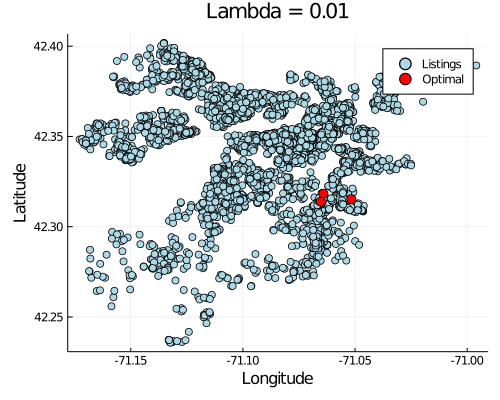

In [10]:
display(map)

### How does lambda affect the outcome?

The model will be run with the following input variables 9 times, each time with a different lambda value.

In [11]:
people = 20 # Number of people needing accommodations
couples = 4 # Number of couples in the group (i.e. can share a bed)
nights = 6 # How many nights accommodation is needed
min_rating = 70; # Minimum overall rating for a listing

lambdas = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
Npts = length(lambdas); # How much weight to give to the cost objective (a series of lambdas will be run)

Note: The next section of code takes a long time to run, as the model will have to be run multiple times with different input for lambda in order to examine how this change affects the optimal solution. As lambda approaches zero, the time it takes for the model to finish processing grows. The main reason for this is the distance matrix being N^2 in size, which means evaluating it takes O(n^2) time for a given solution to the problem. If you plan

In [12]:
indices = Any[]
counts = zeros(Int, Npts)
costs = zeros(Npts)
dists = zeros(Npts)
maps = Any[]

for i in 1:Npts
    (opt, costs[i], dists[i], opt_map) = largeGathering(lambdas[i], people, couples, nights, min_rating)
    counts[i] = length(opt)
    push!(indices, opt)
    push!(maps, opt_map)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
 96.554935 seconds (282.62 k allocations: 853.150 MiB, 0.23% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
100.295340 seconds (282.62 k allocations: 853.150 MiB, 0.23% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
138.169061 seconds (282.62 k allocations: 853.150 MiB, 0.17% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
157.139492 seconds (282.62 k allocations: 853.150 MiB, 0.15% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
171.117704 seconds (282.62 k allocations: 853.150 MiB, 0.14% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
180.014631 seconds (282.62 k allocations: 853.150 MiB, 0.13% gc time)
Academic license

In [25]:
# Indices for the lambda values selected for visualization
s = [2,4,6,8];

To give a more concise snapshot of the output, four lambda values were selected for visualizations. The solutions to these four optimal sets are as follows:

In [26]:
for i in 1:length(s)
    println("Lambda = ", lambdas[s[i]] ,": ")
    println("    - Total Cost = \$", costs[s[i]])
    println("    - Cost Per Night  = \$", costs[s[i]] / nights,)
    println("    - Total Distance = ", dists[s[i]], "km")
    println("    - Optimal Set of Airbnbs:")
    for j in 1:counts[s[i]]
        println("        -> ", id[indices[s[i]][j]], " - ", name[indices[s[i]][j]])
    end
    println()
end

Lambda = 0.5: 
    - Total Cost = $1074.0
    - Cost Per Night  = $179.0
    - Total Distance = 33.51682166906666km
    - Optimal Set of Airbnbs:
        -> 20349970 - Walk To The Beach or City, room 7
        -> 22018975 - Savin Hill-Spacious/Modern 3 BR/2BA close to Train
        -> 23633083 - Hilltop5- 2 Doublebeds 4.6m to BCEC near T freeprk
        -> 36518454 - Shared bedroom close to Fenway & downtown
        -> 42065558 - Boston Fenway Inn

Lambda = 0.05: 
    - Total Cost = $1207.0
    - Cost Per Night  = $201.16666666666666
    - Total Distance = 7.023061705967275km
    - Optimal Set of Airbnbs:
        -> 36259060 - Shared bedroom close to Fenway & downtown Boston
        -> 36518454 - Shared bedroom close to Fenway & downtown
        -> 40302103 - Stylish retreat gather +king mn2 Downtown Freeprkg

Lambda = 0.005: 
    - Total Cost = $1574.0
    - Cost Per Night  = $262.3333333333333
    - Total Distance = 1.3175882044048317km
    - Optimal Set of Airbnbs:
        -> 175928

In [18]:
plot(maps[s[1]],maps[s[2]],maps[s[3]],maps[s[4]], legend = false, size=(900,650))

The above plots give a visual representation of the effect that lambda has on the output. As the value of lambda approaches zero, the optimal set of Airbnbs becomes more and more clustered they become geographically. 

The pareto curve below, which includes the output from all lambda values (not just the selected four), shows what this tradeoff curve looks like. If implemented in a real-world recommendation system, the different lambda variables could be used to give a user a handful of options to choose from. Alternatively, a lambda variable could be directly computed given a user's inputed preference for one over the other.

It should be noted that the pareto curve for this data is not a very smooth curve, however this is expected. Because the data is non-continuous, there is not a direct tradeoff for every dollar. Or in other words, an optimal solution, may be optimal for a range of costs/distances. In this pareto curve for example, there are two pairs of lambda variables with the same exact solution.

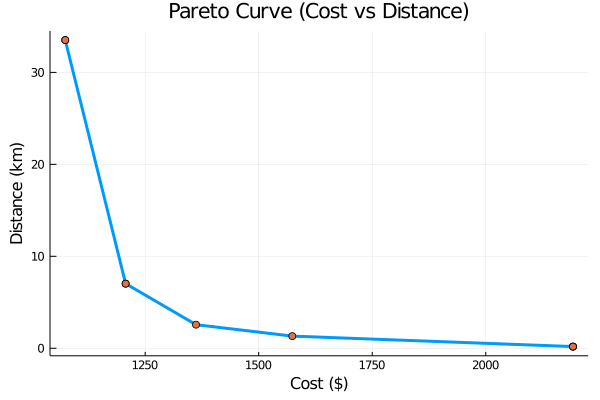

In [27]:
plot( costs, dists, legend = false, xlabel = "Cost (\$)", ylabel = "Distance (km)",
    title = "Pareto Curve (Cost vs Distance)", lw = 3,)
plot!( costs, dists, seriestype = :scatter)

# 5. Conclusion

Although there are many other factors that go into choosing where to stay, this project shows that such a system could work. Through optimization an optimal set of Airbns that solves the problem instance can be found. Furthermore, through the application of weights on the objective functions, a set of optimal solutions can be found for the same problem instance. Ultimately, this project is a proof of concept of how optimization could be used to recommend lodging for more complex problems, and with more data variables (i.e. info about a listing that can be measured), the solution to a given situation can be even more finely tuned.

Future plans for this project:  
- Calendar Availability: The same website that provides this data, also scrapes the calendar availability for each listings. Because of the size of this data, as well as the complexity it would bring to this problem, it wasn't used for this project. However, adding availability as a constraint would make the recommendation system more useful and would create a more interesting problem.
- More accurate distance: While direct point-to-point distance is in fact "accurate," it does not consider whether the direct distance is travelable. For example, a given optimal solution may have a river that seperates the Airbnbs with no bridge in the area. Finding a better optimal solution would require calculating distance by travel time. This in itself, however, would add a much greater complexity to the problem...
- Different Problem Scenarios: This project only solves one type of problem, however the Airbnb data is not limited to just this. There is a wide array of other problem scenarios that could be solved using optimization, such as...
    - planning a multi-city trip, where a budget limits the overall spending on lodging
    - finding the Airbnb with the best quality to cost rations (rating/cost)
    - planning a trip around proximity to specific sight-seeing locations
    